# Summary of Imaging Analyses Results

In [84]:
# imports
import os
import polars as pl
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
import operator
from adjustText import adjust_text

sns.set_style(style='white')
sys.path.append("../../..")
from utils import *

In [2]:
BATCH_LIST_DICT = {
    # "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
    # "2024_02_06_Batch_8": "2024_02_Batch_7-8",
    # "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
    # "2024_12_09_Batch_12": "2024_12_Batch_11-12",
    "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
    "2025_01_28_Batch_14": "2025_01_Batch_13-14",
    # "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
    # "2025_03_17_Batch_16": "2025_03_Batch_15-16"
}

BIO_REP_BATCHES_DICT = {
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

METADATA_INPUT = "../../../../1_allele_collection/3_outputs"
FEAT_SETS = ["DNA", "Mito", "GFP", "AGP", "Morph"]
CLASS_RES_OUTDIR = "../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses"
INTEGRATIVE_INPUT = "../../../../3_integrated_assay_analyses/1_inputs/imaging"

In [3]:
clin_var_df = pl.read_csv(f"{METADATA_INPUT}/varchamp_alleles_with_pillar_annotations.tsv", 
                          separator="\t", infer_schema_length=1000000
).with_columns(
    pl.col("gene_variant").alias("gene_allele"),
)
clin_var_df.head()

symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,gene_allele
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,…,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,str
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Ala148Asp""","""Ala148Asp""",true,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Ala148Asp""","""Ala148Asp""",true,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Ala148Gly""","""Ala148Gly""",true,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Ala148Gly""","""Ala148Gly""",true,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,nul

In [4]:
# priority_col = ["orf_id", "mut_id", "symbol", "aa_change", "gene_allele", "gene_variant", "ensembl_gene_id", "clinvar_clnsig_clean", "gnomad_af", "StarStatus", "pillar_tested"]
clin_var_df = clin_var_df.with_columns( ## .select(priority_col).filter(~pl.col("mut_id").is_null())
    pl.col("mut_id").cast(pl.Int64).alias("mut_id"),
    pl.col("orf_id").cast(pl.Int64).alias("orf_id")
)

In [5]:
cell_count_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_cell-count_changes.csv").rename(
    {"U2OS_paired_t_stat": "U2OS_cc_t_stat", "U2OS_paired_t_pval": "U2OS_cc_t_pval", "Variant": "gene_allele"}
)
prot_abund_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_prot-abundance_changes.csv").rename(
    {"U2OS_paired_t_stat": "U2OS_abun_t_stat", "U2OS_paired_t_pval": "U2OS_abun_t_pval", "Variant": "gene_allele"}
)
auroc_summary_df = pl.read_csv(f"{CLASS_RES_OUTDIR}/3.classification_analyses/2025_01_Batch_13-14/imaging_analyses_classification_summary.csv")
auroc_summary_df

gene_allele,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,Gene
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""SDHD_Gly106Val""","""2025_01_Batch_13-14""",0.778163,0.834339,0.799601,0.858283,0.697296,0.755168,0.807092,0.769505,0.793184,0.672306,0.766665,0.820715,0.784553,0.825733,0.684801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""SDHD"""
"""SOS2_Val869Ile""","""2025_01_Batch_13-14""",0.660541,0.981839,0.996189,0.981104,0.698522,0.799511,0.987445,0.997277,0.993171,0.713993,0.730026,0.984642,0.996733,0.987137,0.706257,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,"""SOS2"""
"""RET_Thr338Ile""","""2025_01_Batch_13-14""",0.917492,0.710512,0.659498,0.59265,0.8981,0.920531,0.902788,0.843026,0.920583,0.829956,0.919012,0.80665,0.751262,0.756617,0.864028,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"""RET"""
"""CCM2_Arg389Trp""","""2025_01_Batch_13-14""",0.879888,0.891073,0.906692,0.907211,0.793835,0.680867,0.848538,0.898244,0.820994,0.59598,0.780377,0.869806,0.902468,0.864102,0.694907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""CCM2"""
"""SHOC2_Ser4Arg""","""2025_01_Batch_13-14""",0.917976,0.918094,0.87941,0.91422,0.866539,0.675518,0.808099,0.742499,0.738974,0.640452,0.796747,0.863096,0.810955,0.826597,0.753496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""SHOC2"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""CCM2_Glu264Asp""","""2025_01_Batch_13-14""",0.904895,0.90019,0.867517,0.888666,0.73532,0.862908,0.901495,0.79773,0.794693,0.796924,0.883902,0.900843,0.832624,0.841679,0.766122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""CCM2"""
"""CCM2_Lys30Glu""","""2025_01_Batch_13-14""",0.84455,0.870647,0.875369,0.870079,0.817052,0.743932,0.775511,0.816843,0.777453,0.733565,0.794241,0.823079,0.846106,0.823766,0.775309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""CCM2"""
"""BRCA1_Thr37Lys""","""2025_01_Batch_13-14""",0.817409,0.909922,0.875146,0.8792,0.667051,0.936526,0.874551,0.911929,0.954337,0.939591,0.876968,0.892236,0.893538,0.916768,0.803321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""BRCA1"""


In [6]:
auroc_summary_df.filter(pl.col("gene_allele").str.contains("RHO"))

gene_allele,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,Gene
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""RHO_Pro267Thr""","""2025_01_Batch_13-14""",0.851346,0.902517,0.99459,0.980275,0.917511,0.955634,0.971574,0.998483,0.994197,0.945688,0.90349,0.937045,0.996537,0.987236,0.931599,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,"""RHO"""
"""RHO_Cys110Tyr""","""2025_01_Batch_13-14""",0.872791,0.970932,0.999353,0.996078,0.979052,0.879082,0.987451,0.999749,0.997256,0.985505,0.875936,0.979191,0.999551,0.996667,0.982279,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,"""RHO"""
"""RHO_Arg135Trp""","""2025_01_Batch_13-14""",0.848451,0.97691,0.999578,0.997115,0.983037,0.828956,0.983734,0.999812,0.998267,0.989435,0.838703,0.980322,0.999695,0.997691,0.986236,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,"""RHO"""
"""RHO_Asp190Gly""","""2025_01_Batch_13-14""",0.783341,0.973871,0.999351,0.997668,0.973984,0.763643,0.979532,0.999559,0.998346,0.980202,0.773492,0.976701,0.999455,0.998007,0.977093,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,"""RHO"""


In [7]:
imaging_summary = cell_count_summary.join(
    prot_abund_summary,
    on=["Gene", "gene_allele"],
    how="full",
    coalesce=True
).join(
    auroc_summary_df,
    on=["Gene", "gene_allele"],
    how="full",
    coalesce=True
).with_columns(
    pl.lit(True).alias("image_assayed")
).join(
    clin_var_df,
    on=["gene_allele"],
    how="left"
)
imaging_summary.write_csv("../../../../3_integrated_assay_analyses/1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t")

In [9]:
imaging_summary.filter(pl.col("gene_allele").str.contains("RHO"))

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,symbol,ensembl_gene_id,orf_id,mut_id,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,str,str,i64,i64,…,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""RHO""","""RHO_Asp190Gly""",-2.929431,0.022042,-16.309158,7.9368e-7,"""2025_01_Batch_13-14""",0.783341,0.973871,0.999351,0.997668,0.973984,0.763643,0.979532,0.999559,0.998346,0.980202,0.773492,0.976701,0.999455,0.998007,0.977093,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,true,"""RHO""",null,40080645,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""RHO_Asp190Gly""","""Asp190Gly""",true
"""RHO""","""RHO_Arg135Trp""",-17.380337,5.1334e-7,-16.193593,8.3324e-7,"""2025_01_Batch_13-14""",0.848451,0.97691,0.999578,0.997115,0.983037,0.828956,0.983734,0.999812,0.998267,0.989435,0.838703,0.980322,0.999695,0.997691,0.986236,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,true,"""RHO""",null,40080645,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""RHO_Arg135Trp""","""Arg135Trp""",true
"""RHO""","""RHO_Pro267Thr""",-6.437157,0.000355,-11.954206,0.000007,"""2025_01_Batch_13-14""",0.851346,0.902517,0.99459,0.980275,0.917511,0.955634,0.971574,0.998483,0.994197,0.945688,0.90349,0.937045,0.996537,0.987236,0.931599,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,true,"""RHO""",null,40080645,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""RHO""","""RHO_Cys110Tyr""",-5.373755,0.001037,-13.627095,0.000003,"""2025_01_Batch_13-14""",0.872791,0.970932,0.999353,0.996078,0.979052,0.879082,0.987451,0.999749,0.997256,0.985505,0.875936,0.979191,0.999551,0.996667,0.982279,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,true,"""RHO""",null,40080645,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,nul

## 2. Plots

In [132]:
def plot_gene_level_summary(df, hit_col, cell_change, gene_order=None, hits_only=True, null_only=False, ax=None):
    total_allele_hit_sum_df = (
        df
        .group_by("Gene")
        .agg([
            pl.len().alias("len"),
            pl.col(hit_col).filter(pl.col(hit_col)).len().alias("len_hits"),
        ])
        .with_columns(
            # compute percentage = hit_count / total_variants * 100
            (pl.col("len_hits") / pl.col("len") * 100)
            .round(1)
            .alias("pct_hits")
        )
        # # sort by total_variants descending just for nicer plotting order
        # .sort(["pct_hits", "len"], descending=False)
    )

    if hits_only:
        total_allele_hit_sum_df = total_allele_hit_sum_df.filter(
            pl.col("pct_hits") > 0
        ).to_pandas()
    elif null_only:
        total_allele_hit_sum_df = total_allele_hit_sum_df.filter(
            pl.col("pct_hits") == 0
        ).to_pandas()
    else:
        total_allele_hit_sum_df = total_allele_hit_sum_df.to_pandas()

    if (gene_order is None):
        total_allele_hit_sum_df = total_allele_hit_sum_df.set_index("Gene")
    else:
        total_allele_hit_sum_df = total_allele_hit_sum_df.set_index("Gene").loc[gene_order,:]

    # display(total_allele_hit_sum_df)
    
    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_width = 0.6
    if ax is None:
        fig_height = max(6, min(n_genes * 0.3, 40))  # cap size for huge plots
        fig_width = 8
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Plot bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percentage
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.iloc[i, 0] + 0.1,
            i,
            f"{pct:.1f}%",
            ha="left",
            va="center",
            fontsize=9 if n_genes > 20 else 11,
            rotation=0,
        )
        
    # Axis formatting
    ax.set_yticks(y)
    ax.set_yticklabels(
        total_allele_hit_sum_df.index,
        fontsize=9 if n_genes > 20 else 11,
    )
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"{cell_change.upper()} Hits per Gene",
        fontsize=13,
    )
    ax.set_xlim(0, total_allele_hit_sum_df["len"].max()+20)
    ax.set_ylim(-0.5, len(y) + -.3)
    ax.legend(fontsize=11, loc="lower right")

In [133]:
imaging_summary = imaging_summary.with_columns(
    pl.col("symbol").str.replace_all(r"[^A-Za-z0-9\.]", "").alias("symbol"),
    pl.col("gene_variant").str.replace_all(r"[^A-Za-z0-9\.]", "").alias("gene_variant") 
)

hue_order = sorted(imaging_summary.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
gene_order = imaging_summary.unique("gene_variant").filter(
        ~pl.col("gene_variant").str.contains("CCM2")
    ).group_by("symbol").agg(
    pl.len()
).sort("len", descending=False)["symbol"]
auroc_cols = sorted([col for col in imaging_summary.columns if col.startswith("AUROC_Mean")])
alter_95th_cols = sorted([col for col in imaging_summary.columns if col.startswith("Altered_95th_perc")])

<Figure size 640x480 with 0 Axes>

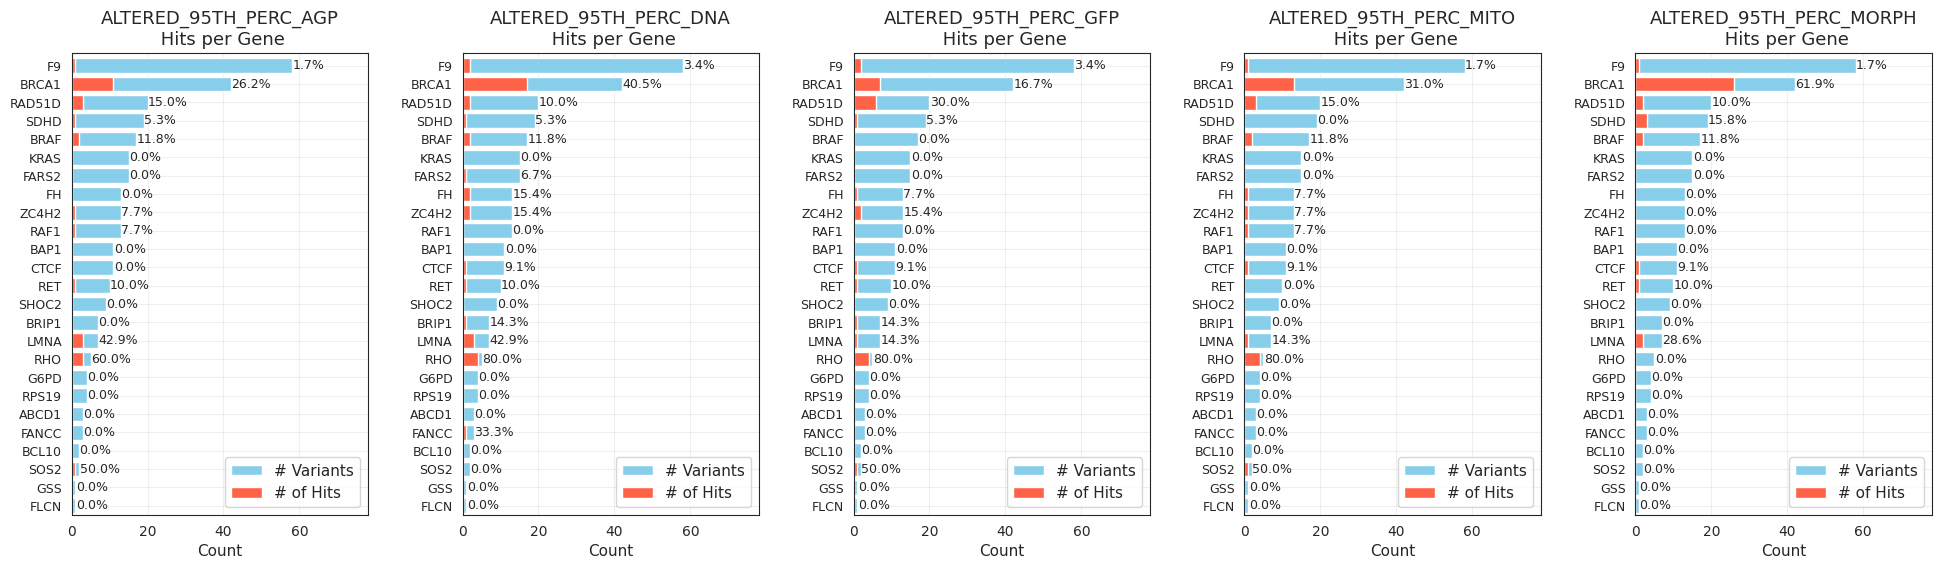

In [134]:
plt.clf()
fig, ax = plt.subplots(1,5,figsize=(24, 6))

for i, col in enumerate(alter_95th_cols):
    plot_gene_level_summary(imaging_summary.unique("gene_variant").with_columns(
        pl.col(col).cast(pl.Boolean).alias(col)
    ).filter(
        ~pl.col("gene_variant").str.contains("CCM2")
    ), col, col+"\n", gene_order=gene_order, hits_only=False, ax=ax[i])
    ax[i].grid(alpha=.3)

plt.subplots_adjust(wspace=.32)
plt.show()

<Figure size 640x480 with 0 Axes>

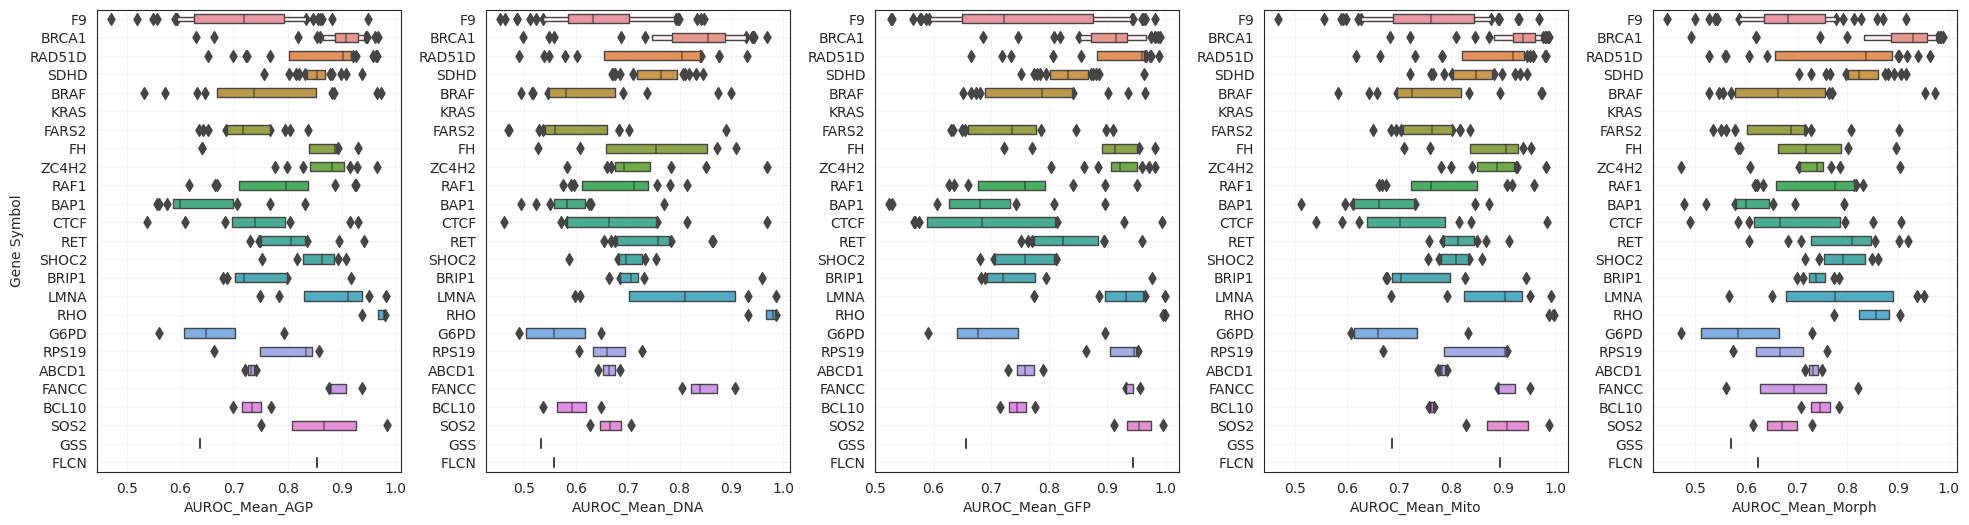

In [137]:
plt.clf()
fig, ax = plt.subplots(1,5,figsize=(24, 6))
for i, col in enumerate(auroc_cols):
    sns.boxenplot(data=imaging_summary.unique("gene_variant").filter(
        (pl.col("Gene")!="KRAS")&(pl.col("Gene")!="CCM2")
    ).to_pandas(), x=col, y="Gene", ax=ax[i], width=.5, 
                 order=gene_order[::-1])
    # ax.set_xlabel("AUROC_Mean_GFP")
    ax[i].set_ylabel("")
    ax[i].grid(alpha=0.2)
ax[0].set_ylabel("Gene Symbol")
plt.subplots_adjust(wspace=.28)
plt.show()

In [50]:
img_pillar_df = imaging_summary.filter(pl.col("pillar_tested")).unique("gene_variant")
img_pillar_df

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,symbol,ensembl_gene_id,orf_id,mut_id,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,str,str,i64,i64,…,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""F9""","""F9_Val227Ile""",-2.37369,0.049338,2.613116,0.034755,"""2025_01_Batch_13-14""",0.655818,0.6025,0.569804,0.659162,0.575691,0.428937,0.578322,0.629959,0.621918,0.398167,0.542377,0.590411,0.599881,0.64054,0.486929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,"""F9""",null,52861,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Val227Ile""","""Val227Ile""",true
"""F9""","""F9_Ile443Thr""",-2.603127,0.035264,0.882886,0.406595,"""2025_01_Batch_13-14""",0.700658,0.634948,0.744649,0.757524,0.589515,0.579538,0.625417,0.751156,0.736371,0.577052,0.640098,0.630182,0.747902,0.746947,0.583283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,"""F9""",null,52861,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Ile443Thr""","""Ile443Thr""",true
"""CTCF""","""CTCF_Arg342Cys""",4.025115,0.005027,3.346591,0.012308,"""2025_01_Batch_13-14""",0.732362,0.798079,0.74144,0.695616,0.705167,0.643557,0.678915,0.686228,0.709388,0.544251,0.687959,0.738497,0.713834,0.702502,0.624709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,"""CTCF""",null,6173,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_Arg342Cys""","""Arg342Cys""",true
"""F9""","""F9_Asp110Asn""",1.793002,0.116067,1.759954,0.12181,"""2025_01_Batch_13-14""",0.882632,0.743624,0.755014,0.878154,0.727894,0.634524,0.697266,0.660322,0.756031,0.574292,0.758578,0.720445,0.707668,0.817092,0.651093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,"""F9""","""ENSG00000101981""",52861,204357,…,null,null,null,null,null,null,null,null,null,null,null,null,null,

In [140]:
scores = img_pillar_df
gene_order_pillar = scores.unique("gene_variant").filter(
        ~pl.col("gene_variant").str.contains("CCM2")
    ).group_by("symbol").agg(
    pl.len()
).sort("len", descending=False)["symbol"]

<Figure size 640x480 with 0 Axes>

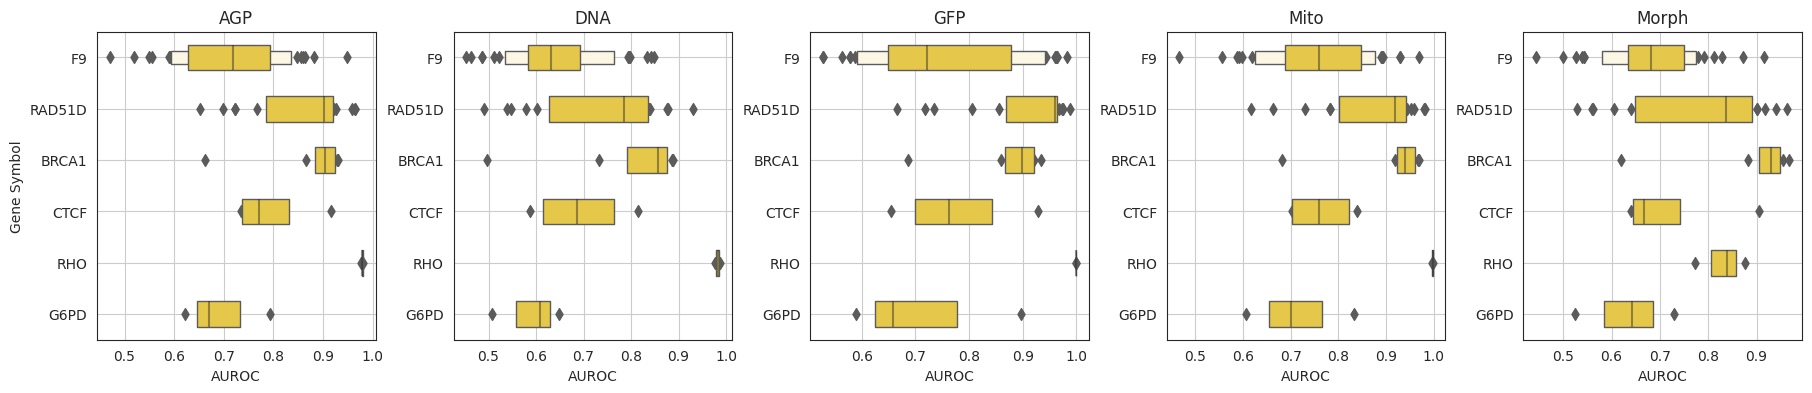

In [149]:
plt.clf()
fig, ax = plt.subplots(1,5,figsize=(22, 4))
for i, col in enumerate(auroc_cols):
    sns.boxenplot(data=img_pillar_df.unique("gene_variant").filter(pl.col("Gene")!="KRAS").to_pandas(),
                  # palette=palette_dict["clinvar_clnsig_clean"], 
                # hue="clinvar_clnsig_clean", 
                # hue_order=hue_order,
                  color=sns.color_palette("Set2")[-3],
                  order=gene_order_pillar[::-1],
                  # gap=.2,
                x=col, y="Gene", ax=ax[i], width=.5)
    ax[i].set_xlabel("AUROC")
    ax[i].set_ylabel("")
    ax[i].set_title(col.split("_")[-1])
    ax[i].grid()
ax[0].set_ylabel("Gene Symbol")
plt.subplots_adjust(wspace=.28)
plt.show()

<Figure size 640x480 with 0 Axes>

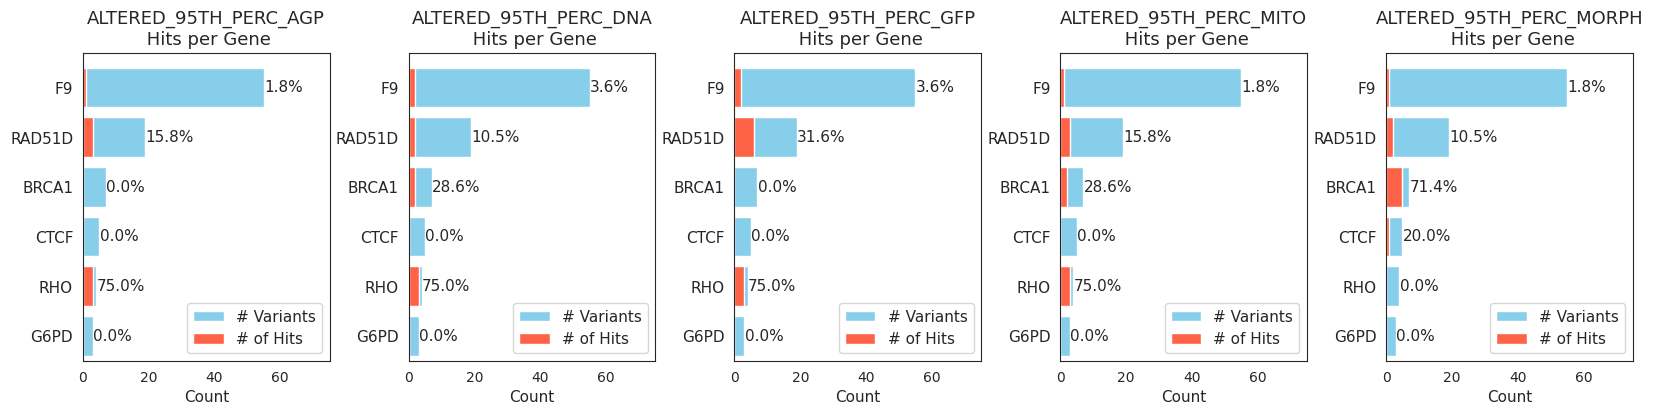

In [139]:

plt.clf()
fig, ax = plt.subplots(1,5,figsize=(20, 4))
for i, col in enumerate(alter_95th_cols):
    plot_gene_level_summary(scores.with_columns(
        pl.col(col).cast(pl.Boolean).alias(col)
    ), col, col+"\n", gene_order=gene_order_pillar, hits_only=False, ax=ax[i])

# fig, ax = plt.subplots(1,1,figsize=(6,15))
# plot_gene_level_summary(scores, "Altered_95th_perc_Morph", "Altered_95th_perc_Morph", hits_only=False, null_only=True, ax=ax)

# fig, ax = plt.subplots(1,1,figsize=(6,4))
# plot_gene_level_summary(func_scores, "dualipa_abund_change", "DUAL-IPA Abundance Change Pillar Variants", hits_only=False, ax=ax)
plt.subplots_adjust(wspace=.32)
plt.show()

gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_Morph,Altered_95th_perc_Morph
str,str,str,str,str,f64,f64
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.881766,0.0
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.927047,1.0
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.955578,1.0
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.620069,0.0
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.940271,1.0
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.930671,1.0
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.967725,1.0


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_AGP,Altered_95th_perc_AGP
str,str,str,str,str,f64,f64
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.663015,0.0
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.930422,0.0
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.918189,0.0
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.901028,0.0
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.928097,0.0
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.903605,0.0
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.865099,0.0


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_GFP,Altered_95th_perc_GFP
str,str,str,str,str,f64,f64
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.872209,0.0
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.919332,0.0
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.86021,0.0
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.899079,0.0
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.685848,0.0
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.9335,0.0
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.921312,0.0


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_Mito,Altered_95th_perc_Mito
str,str,str,str,str,f64,f64
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.928145,0.0
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.940053,0.0
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.919005,0.0
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.681612,0.0
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.969432,1.0
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.967036,1.0
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.956083,0.0


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_DNA,Altered_95th_perc_DNA
str,str,str,str,str,f64,f64
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.887589,1.0
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.851588,0.0
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.497403,0.0
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.857109,0.0
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.866001,0.0
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.886519,1.0
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.733135,0.0


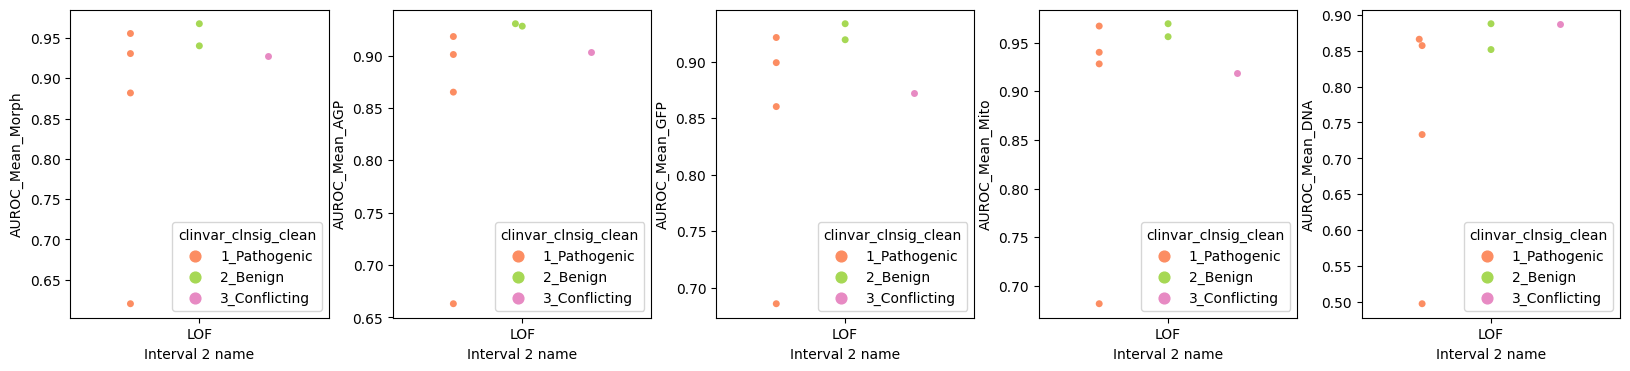

In [81]:
func_scores = imaging_summary.filter(pl.col("pillar_tested"))
pl.Config.set_tbl_rows(25)  # Show all rows

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for x, col in enumerate(auroc_cols):
    for i in range(1,7):
        if i != 2:
            continue
        int_name = f"Interval {i} name"
        mavedb_name = f"Interval {i} MaveDB class"
        func_mave = func_scores.drop_nulls(pl.col(mavedb_name))
        if func_mave.shape[0] > 0:
            # display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name, "zscore_log2"])
            # fig, ax = plt.subplots(1,2,figsize=(15,6))
            hue_order = sorted(func_mave.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
            sns.swarmplot(
                data=func_mave.unique(subset="gene_variant").to_pandas(),
                x=int_name,
                y=col,
                ax=axes.flatten()[x],
                palette=palette_dict["clinvar_clnsig_clean"], 
                hue="clinvar_clnsig_clean", 
                hue_order=hue_order,
                dodge="auto",
                # width=.6,
            )
            display(func_mave.unique(subset="gene_variant").select(
                ["gene_variant", "gene_variant_pp","clinvar_clnsig_clean", int_name, mavedb_name, col, alter_95th_cols[x]]
            ))
            # axes.flatten()[i-1].axhline(func_mave["dualipa_threshold"].to_numpy()[0], color="tomato", linestyle="--")
            # sns.boxenplot(
            #     data=func_mave.unique(subset="gene_variant").to_pandas(),
            #     x=mavedb_name,
            #     y="zscore_log2",
            #     ax=ax[1],
            #     palette=palette_dict["clinvar_clnsig_clean"],
            #     hue="clinvar_clnsig_clean", 
            #     hue_order=hue_order,
            #     dodge=True
            # )
        # else:
        #     fig.delaxes(axes.flatten()[i-1])

    # fig.delaxes(axes.flatten()[6])
    # fig.delaxes(axes.flatten()[7])
    plt.subplots_adjust(wspace=0.25)
    
plt.show()